In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: []


In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/weather/dataset'
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# Verify dataset structure and count files
categories = ['Snow', 'Rain', 'Fogsmog', 'Lightning', 'Rainbow']
print("Dataset Structure Verification:")
print("="*50)

total_files = 0
class_counts = {}

for category in categories:
    category_path = os.path.join(DATASET_PATH, category)
    if os.path.exists(category_path):
        file_count = len([f for f in os.listdir(category_path)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[category] = file_count
        total_files += file_count
        print(f"{category}: {file_count} files")
    else:
        print(f"ERROR: {category} folder not found!")

print(f"\nTotal files: {total_files}")
print("="*50)

Dataset Structure Verification:
Snow: 621 files
Rain: 536 files
Fogsmog: 851 files
Lightning: 377 files
Rainbow: 232 files

Total files: 2617


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Normalize pixels to [0,1]
    rotation_range=20,                 # Random rotation
    width_shift_range=0.2,             # Random horizontal shift
    height_shift_range=0.2,            # Random vertical shift
    shear_range=0.2,                   # Shear transformation
    zoom_range=0.2,                    # Random zoom
    horizontal_flip=True,              # Random horizontal flip
    fill_mode='nearest',               # Fill strategy for new pixels
    validation_split=0.25              # 25% for validation, 75% for training
)


validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25
)


print("Creating data generators...")

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Display class information
print("\nClass Labels Mapping:")
class_labels = train_generator.class_indices
print(class_labels)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")

Creating data generators...
Found 1964 images belonging to 5 classes.
Found 653 images belonging to 5 classes.

Class Labels Mapping:
{'Fogsmog': 0, 'Lightning': 1, 'Rain': 2, 'Rainbow': 3, 'Snow': 4}

Training samples: 1964
Validation samples: 653
Number of classes: 5


In [ ]:
print("\nBuilding CNN model with MobileNetV2 transfer learning...")


base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)


base_model.trainable = False

# Add custom classification layers
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')  # 5 classes: Snow, Rain, Fogsmog, Lightning, Rainbow
])


model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
print("\nModel Architecture:")
model.summary()

print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")



Building CNN model with MobileNetV2 transfer learning...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,533 (9.27 MB)

 Trainable params: 172,549 (674.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Total parameters: 2,430,533
Trainable parameters: 172,549


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

In [ ]:
print(f"\nStarting training for {EPOCHS} epochs...")
print("="*60)


steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")


history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")


Starting training for 20 epochs...
Steps per epoch: 61
Validation steps: 20
Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 760s 12s/step - accuracy: 0.2789 - loss: 1.9974 - val_accuracy: 0.6078 - val_loss: 1.0919 - learning_rate: 1.0000e-04
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 279ms/step - accuracy: 0.4688 - loss: 1.2531 - val_accuracy: 0.6094 - val_loss: 1.0862 - learning_rate: 1.0000e-04
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.4699 - loss: 1.3648 - val_accuracy: 0.7453 - val_loss: 0.8171 - learning_rate: 1.0000e-04
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.5312 - loss: 1.1389 - val_accuracy: 0.7500 - val_loss: 0.8128 - learning_rate: 1.0000e-04
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 68s 997ms/step - accuracy: 0.5992 - loss: 1.0899 - val_accuracy: 0.8156 - val_loss: 0.6362 - learning_rate: 1.0000e-04
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.5938 - loss: 1.0683 - val_accuracy: 0.8156 - val_loss: 0.6329 - learning_ra


Generating training history plots...


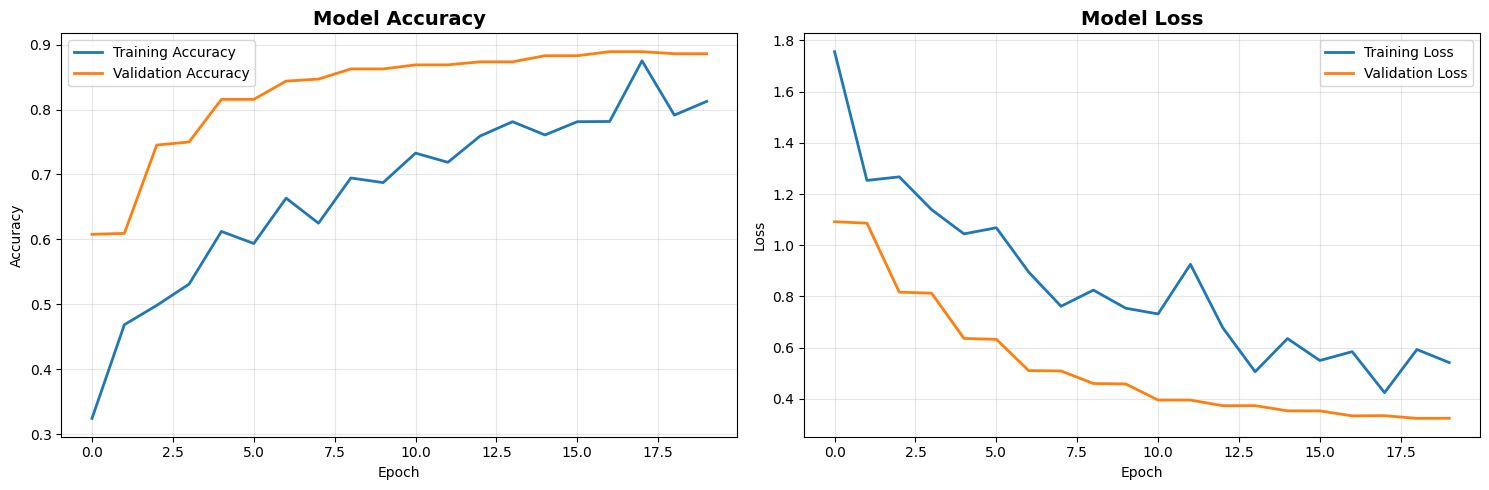

Final Training Accuracy: 0.8750 (87.50%)
Final Validation Accuracy: 0.8891 (88.91%)
🎉 TARGET ACHIEVED: Validation accuracy >= 80%!


In [ ]:
print("\nGenerating training history plots...")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display final metrics
final_train_acc = max(history.history['accuracy'])
final_val_acc = max(history.history['val_accuracy'])

print(f"Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

if final_val_acc >= 0.80:
    print("🎉 TARGET ACHIEVED: Validation accuracy >= 80%!")
else:
    print("⚠️  Target not yet reached. Consider more training or hyperparameter tuning.")

In [ ]:
print("\nEvaluating model performance...")

# Get predictions for validation set
validation_generator.reset()
predictions = model.predict(validation_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = validation_generator.classes
class_labels_list = list(validation_generator.class_indices.keys())

# Classification Report
print("\nClassification Report:")
print("="*60)
report = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_labels_list,
    digits=4
)
print(report)


Evaluating model performance...
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 672ms/step

Classification Report:
              precision    recall  f1-score   support

     Fogsmog     0.8712    0.9575    0.9124       212
   Lightning     0.9485    0.9787    0.9634        94
        Rain     0.8640    0.8060    0.8340       134
     Rainbow     0.9636    0.9138    0.9381        58
        Snow     0.8671    0.8000    0.8322       155

    accuracy                         0.8882       653
   macro avg     0.9029    0.8912    0.8960       653
weighted avg     0.8881    0.8882    0.8869       653




Generating Confusion Matrix...


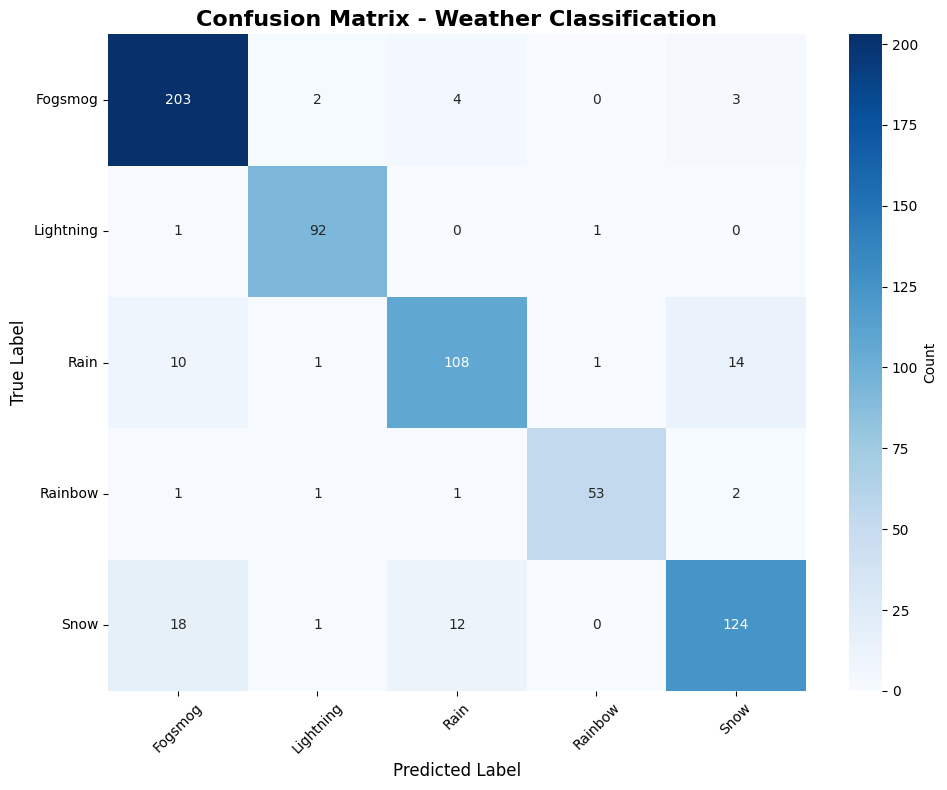


Per-Class Accuracy:
------------------------------
Fogsmog: 0.9575 (95.75%)
Lightning: 0.9787 (97.87%)
Rain: 0.8060 (80.60%)
Rainbow: 0.9138 (91.38%)
Snow: 0.8000 (80.00%)

Saving trained model...
Model saved successfully at: /content/drive/MyDrive/Colab Notebooks/weather/weather_cnn_model.h5
Model architecture saved at: /content/drive/MyDrive/Colab Notebooks/weather/weather_cnn_architecture.json


In [ ]:
print("\nGenerating Confusion Matrix...")

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels_list,
    yticklabels=class_labels_list,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Weather Classification', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-Class Accuracy:")
print("-" * 30)
for i, class_name in enumerate(class_labels_list):
    print(f"{class_name}: {class_accuracy[i]:.4f} ({class_accuracy[i]*100:.2f}%)")



print("\nSaving trained model...")

# Save model in HDF5 format
model_save_path = '/content/drive/MyDrive/Colab Notebooks/weather/weather_cnn_model.h5'
model.save(model_save_path)
print(f"Model saved successfully at: {model_save_path}")

# Save model architecture as JSON
model_json = model.to_json()
json_save_path = '/content/drive/MyDrive/Colab Notebooks/weather/weather_cnn_architecture.json'
with open(json_save_path, 'w') as json_file:
    json_file.write(model_json)
print(f"Model architecture saved at: {json_save_path}")

In [ ]:
def predict_weather(image_path, model, class_labels_list):
    """
    Predict weather category for a new image

    Args:
        image_path (str): Path to the image file
        model: Trained CNN model
        class_labels_list (list): List of class labels

    Returns:
        tuple: (predicted_class, confidence, all_probabilities)
    """
    from tensorflow.keras.preprocessing import image

    # Load and preprocess image
    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_labels_list[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx]

    return predicted_class, confidence, predictions[0]

def display_prediction_results(image_path, model, class_labels_list):
    """
    Display prediction results with visualization
    """
    from tensorflow.keras.preprocessing import image
    import matplotlib.pyplot as plt

    # Make prediction
    predicted_class, confidence, all_probs = predict_weather(image_path, model, class_labels_list)

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Display image
    img = image.load_img(image_path, target_size=(150, 150))
    ax1.imshow(img)
    ax1.set_title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2%}',
                  fontsize=14, fontweight='bold')
    ax1.axis('off')

    # Display probability distribution
    colors = plt.cm.viridis(np.linspace(0, 1, len(class_labels_list)))
    bars = ax2.bar(class_labels_list, all_probs, color=colors)
    ax2.set_title('Prediction Probabilities', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Probability')
    ax2.set_ylim(0, 1)

    # Highlight the predicted class
    max_idx = np.argmax(all_probs)
    bars[max_idx].set_color('red')

    # Add probability values on bars
    for i, (bar, prob) in enumerate(zip(bars, all_probs)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{prob:.3f}', ha='center', va='bottom', fontsize=10)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"Prediction: {predicted_class}")
    print(f"Confidence: {confidence:.2%}")
    print("\nAll probabilities:")
    for label, prob in zip(class_labels_list, all_probs):
        print(f"  {label}: {prob:.4f} ({prob*100:.2f}%)")

# Example usage of prediction function
print("\nPrediction functions created successfully!")
print("\nTo use the prediction function on a new image:")
print("predicted_class, confidence, probabilities = predict_weather('path/to/image.jpg', model, class_labels_list)")
print("display_prediction_results('path/to/image.jpg', model, class_labels_list)")



print("\n" + "="*70)
print("WEATHER CLASSIFICATION MODEL - FINAL SUMMARY")
print("="*70)

print(f"Dataset Information:")
print(f"  • Total Images: {total_files}")
print(f"  • Classes: {len(class_labels_list)}")
for label, count in class_counts.items():
    print(f"  • {label}: {count} images")

print(f"\nModel Configuration:")
print(f"  • Architecture: CNN with MobileNetV2 Transfer Learning")
print(f"  • Input Size: {IMG_SIZE}")
print(f"  • Batch Size: {BATCH_SIZE}")
print(f"  • Learning Rate: {LEARNING_RATE}")
print(f"  • Total Parameters: {model.count_params():,}")

print(f"\nTraining Results:")
print(f"  • Epochs Trained: {len(history.history['accuracy'])}")
print(f"  • Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"  • Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

target_status = "✅ ACHIEVED" if final_val_acc >= 0.80 else "❌ NOT YET REACHED"
print(f"  • Target (≥80% accuracy): {target_status}")

print(f"\nModel Files Saved:")
print(f"  • Model: {model_save_path}")
print(f"  • Architecture: {json_save_path}")

print("\n" + "="*70)
print("Training completed successfully! The model is ready for deployment.")
print("="*70)


Prediction functions created successfully!

To use the prediction function on a new image:
predicted_class, confidence, probabilities = predict_weather('path/to/image.jpg', model, class_labels_list)
display_prediction_results('path/to/image.jpg', model, class_labels_list)

WEATHER CLASSIFICATION MODEL - FINAL SUMMARY
Dataset Information:
  • Total Images: 2617
  • Classes: 5
  • Snow: 621 images
  • Rain: 536 images
  • Fogsmog: 851 images
  • Lightning: 377 images
  • Rainbow: 232 images

Model Configuration:
  • Architecture: CNN with MobileNetV2 Transfer Learning
  • Input Size: (150, 150)
  • Batch Size: 32
  • Learning Rate: 0.0001
  • Total Parameters: 2,430,533

Training Results:
  • Epochs Trained: 20
  • Final Training Accuracy: 0.8750 (87.50%)
  • Final Validation Accuracy: 0.8891 (88.91%)
  • Target (≥80% accuracy): ✅ ACHIEVED

Model Files Saved:
  • Model: /content/drive/MyDrive/Colab Notebooks/weather/weather_cnn_model.h5
  • Architecture: /content/drive/MyDrive/Colab Not

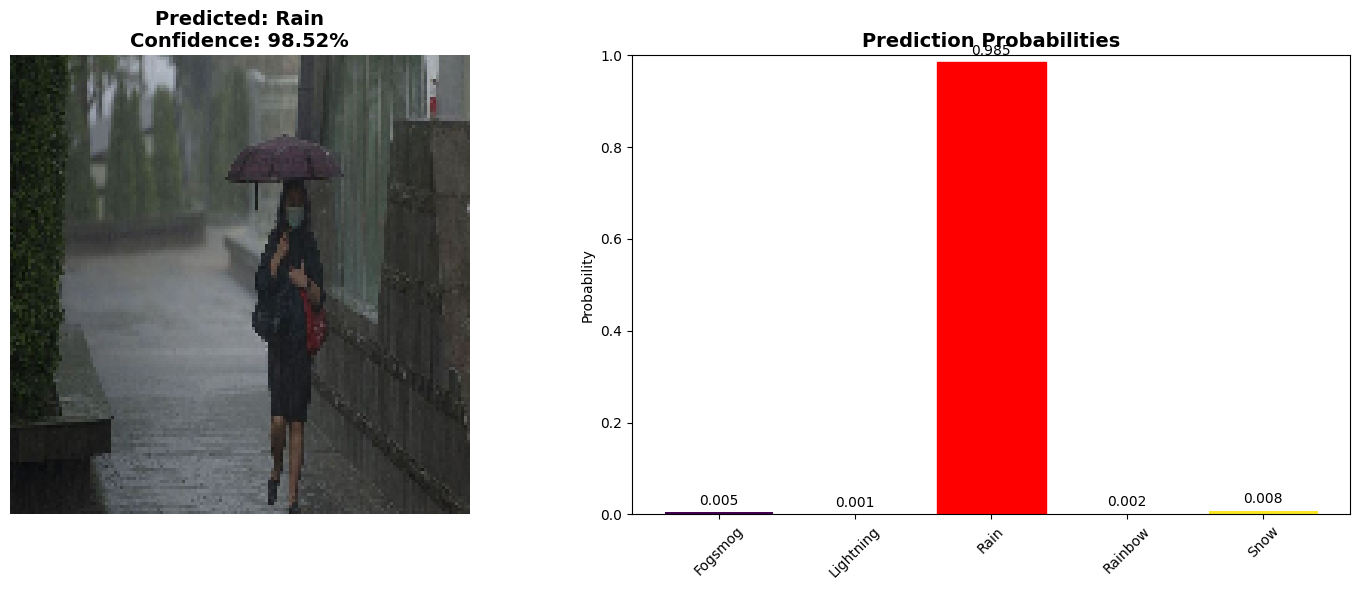

Prediction: Rain
Confidence: 98.52%

All probabilities:
  Fogsmog: 0.0047 (0.47%)
  Lightning: 0.0005 (0.05%)
  Rain: 0.9852 (98.52%)
  Rainbow: 0.0019 (0.19%)
  Snow: 0.0077 (0.77%)


In [ ]:
# Example usage with another image path
# Replace 'path/to/your/image.jpg' with the actual path to your image file
display_prediction_results('/content/drive/MyDrive/Colab Notebooks/weather/dataset/hujan.jpg', model, class_labels_list)

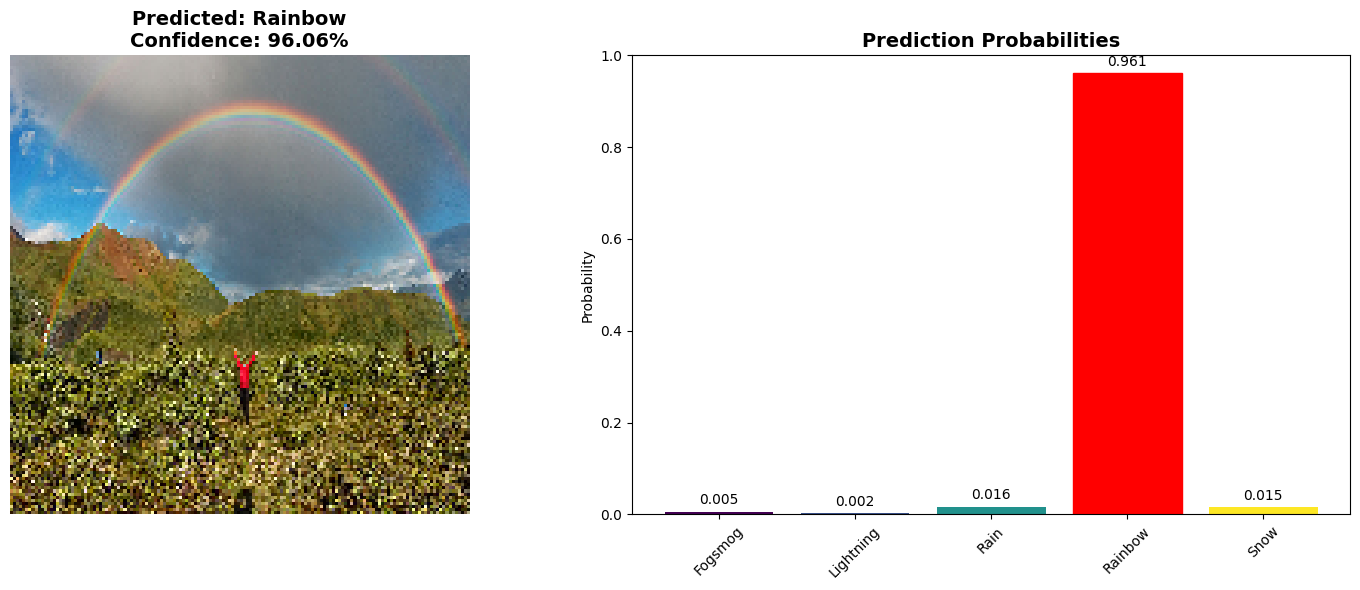

Prediction: Rainbow
Confidence: 96.06%

All probabilities:
  Fogsmog: 0.0054 (0.54%)
  Lightning: 0.0022 (0.22%)
  Rain: 0.0165 (1.65%)
  Rainbow: 0.9606 (96.06%)
  Snow: 0.0154 (1.54%)


In [ ]:
display_prediction_results('/content/drive/MyDrive/Colab Notebooks/weather/dataset/pelangi.jpg', model, class_labels_list)

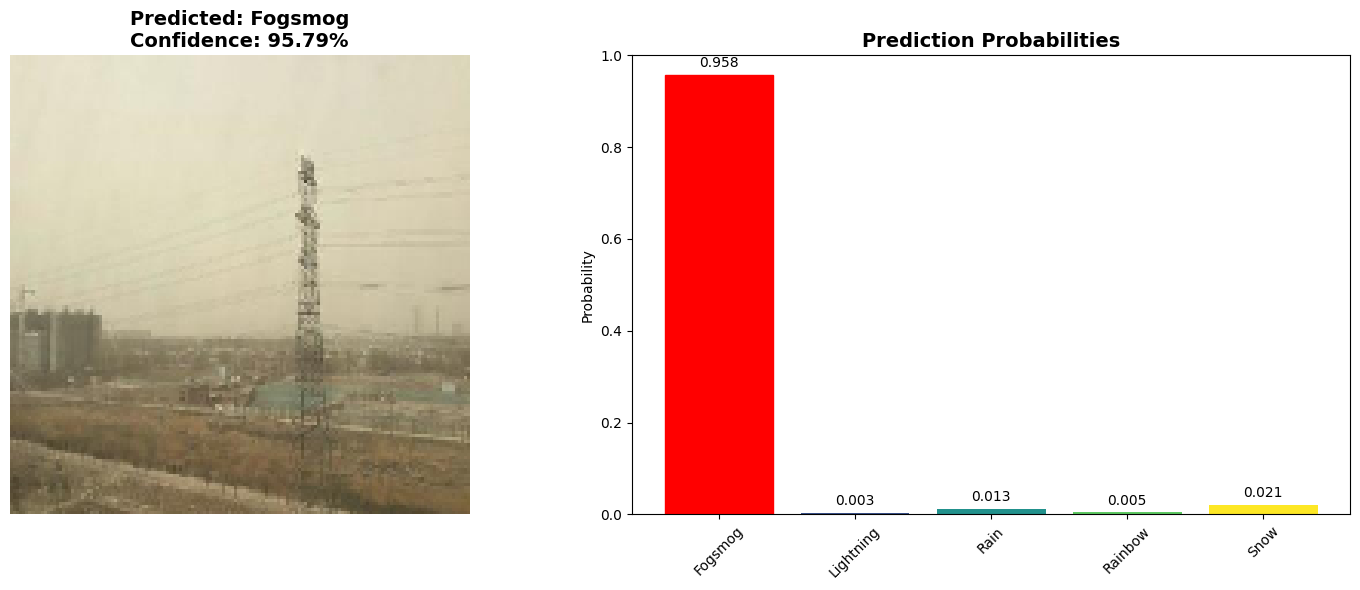

Prediction: Fogsmog
Confidence: 95.79%

All probabilities:
  Fogsmog: 0.9579 (95.79%)
  Lightning: 0.0035 (0.35%)
  Rain: 0.0128 (1.28%)
  Rainbow: 0.0046 (0.46%)
  Snow: 0.0213 (2.13%)


In [ ]:
display_prediction_results('/content/drive/MyDrive/Colab Notebooks/weather/dataset/2929.jpg', model, class_labels_list)

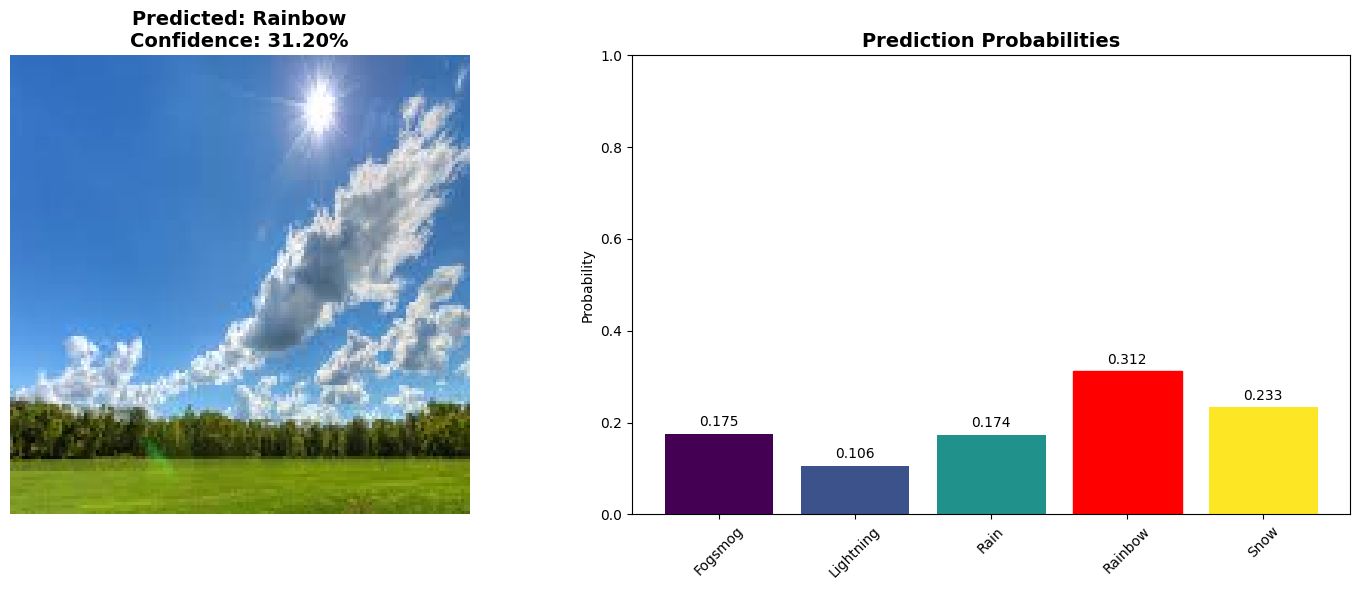

Prediction: Rainbow
Confidence: 31.20%

All probabilities:
  Fogsmog: 0.1752 (17.52%)
  Lightning: 0.1060 (10.60%)
  Rain: 0.1738 (17.38%)
  Rainbow: 0.3120 (31.20%)
  Snow: 0.2330 (23.30%)


In [ ]:
display_prediction_results('/content/drive/MyDrive/Colab Notebooks/weather/dataset/rain.jpg', model, class_labels_list)

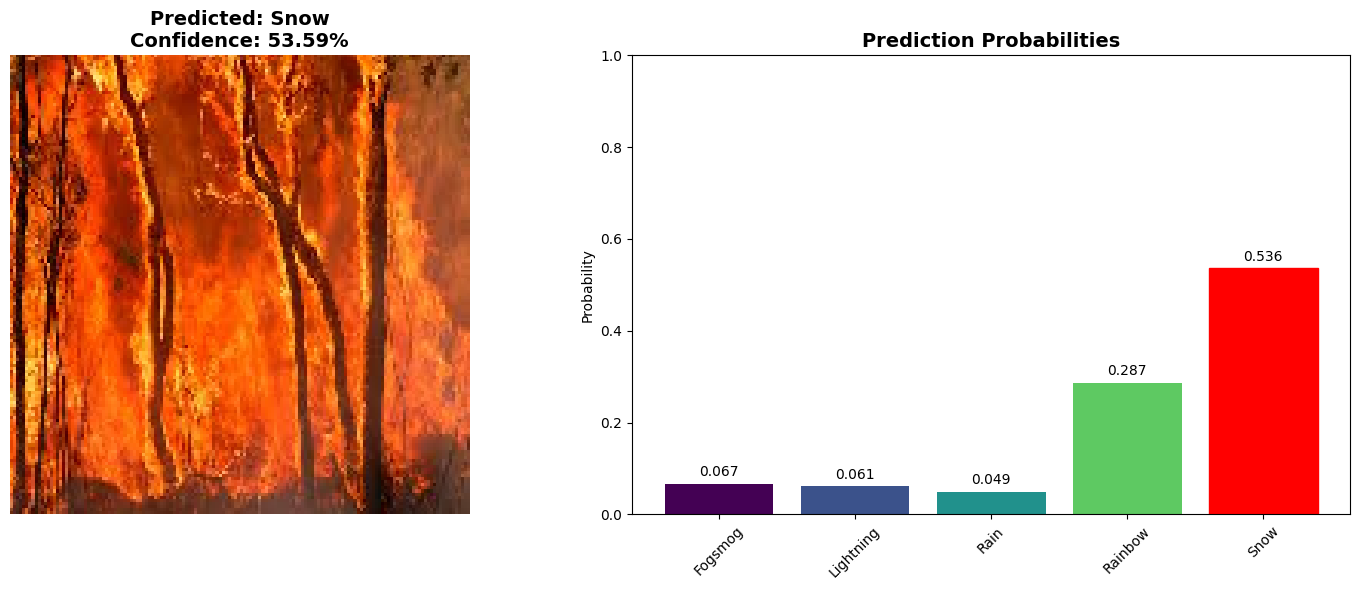

Prediction: Snow
Confidence: 53.59%

All probabilities:
  Fogsmog: 0.0665 (6.65%)
  Lightning: 0.0614 (6.14%)
  Rain: 0.0493 (4.93%)
  Rainbow: 0.2869 (28.69%)
  Snow: 0.5359 (53.59%)


In [ ]:
display_prediction_results('/content/drive/MyDrive/Colab Notebooks/weather/dataset/Fafafaa.jpg', model, class_labels_list)

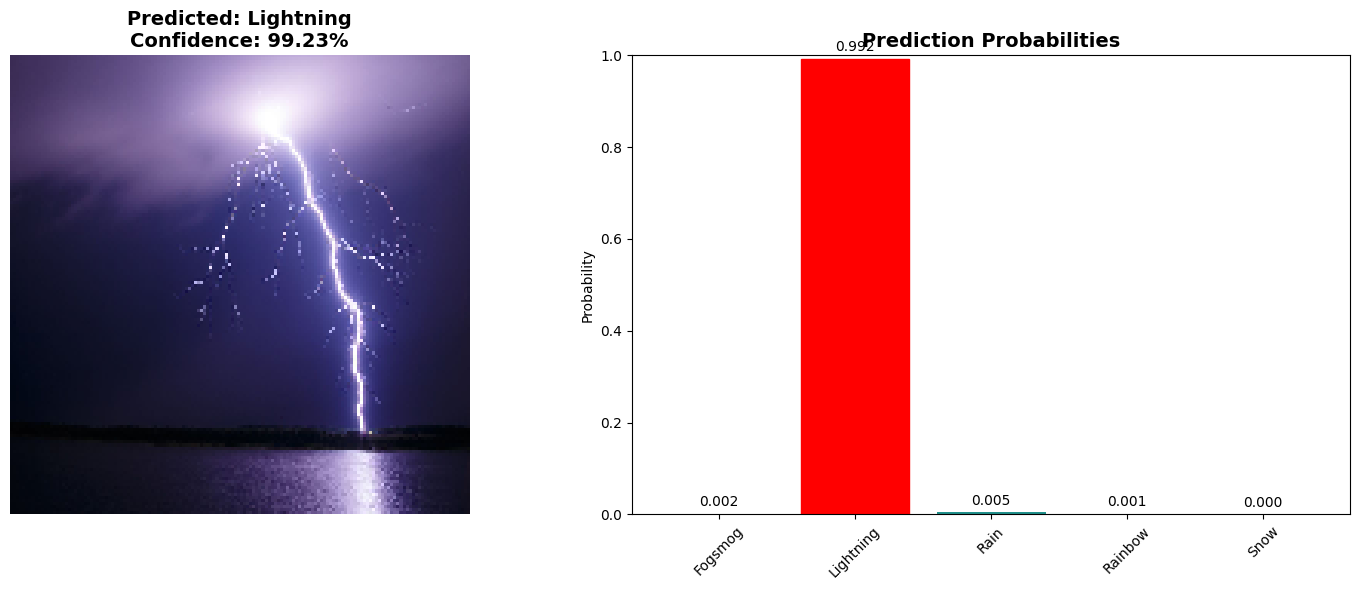

Prediction: Lightning
Confidence: 99.23%

All probabilities:
  Fogsmog: 0.0017 (0.17%)
  Lightning: 0.9923 (99.23%)
  Rain: 0.0049 (0.49%)
  Rainbow: 0.0011 (0.11%)
  Snow: 0.0001 (0.01%)


In [ ]:
display_prediction_results('/content/drive/MyDrive/Colab Notebooks/weather/dataset/gal.jpg', model, class_labels_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


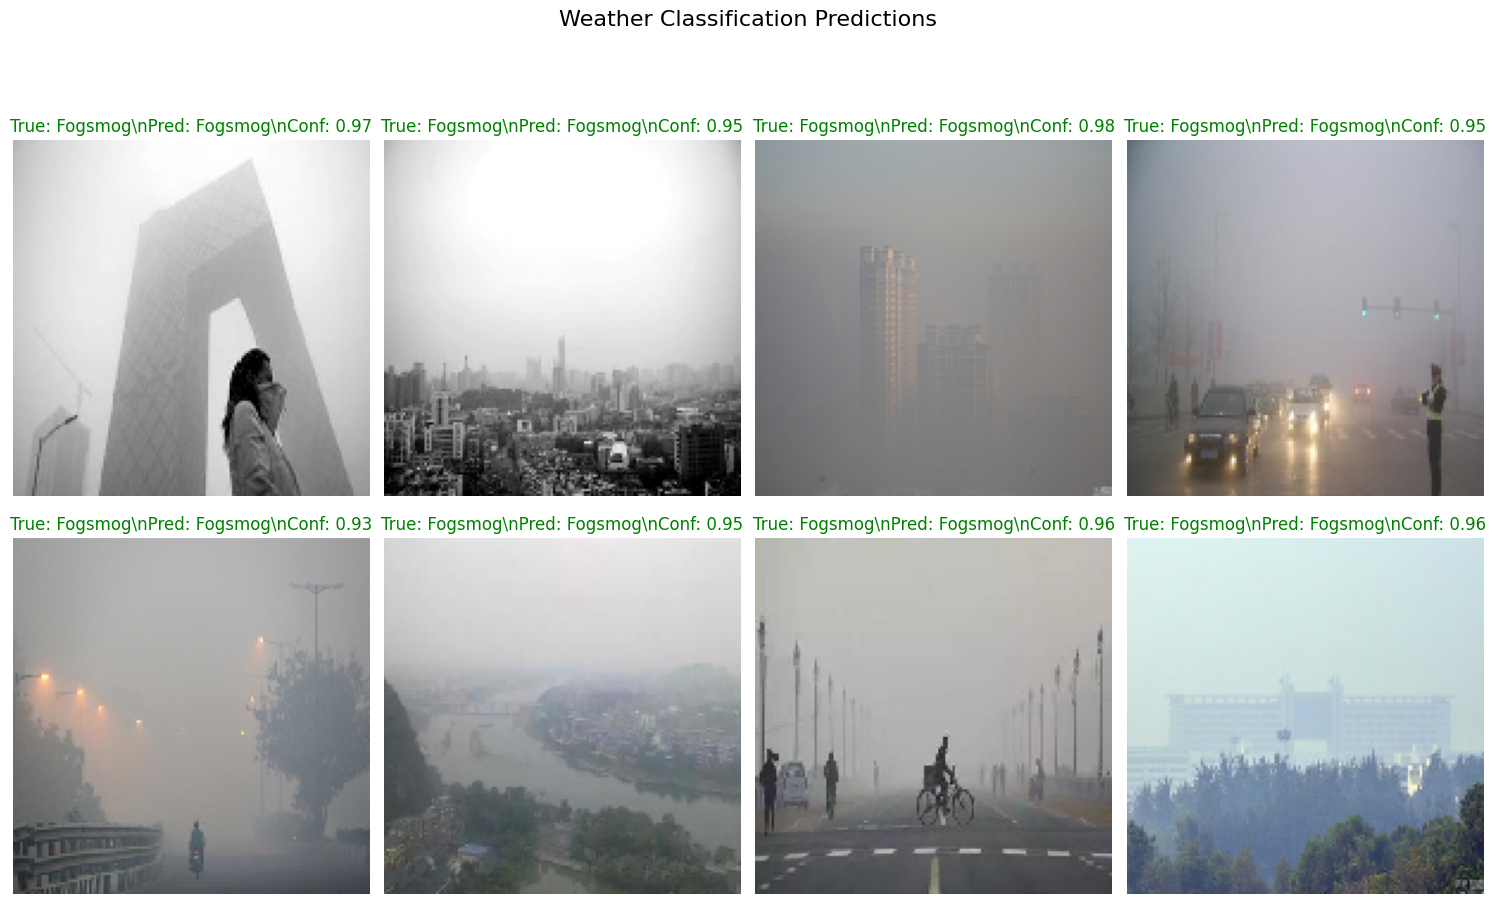

In [ ]:
def plot_predictions(model, generator, class_labels_list, num_images=8):
    # Ensure the generator is reset to get fresh batches
    generator.reset()

    # Get a batch of images and labels from the generator
    images, true_labels = next(generator)

    # Make predictions
    predictions = model.predict(images)

    plt.figure(figsize=(15, 10))
    plt.suptitle("Weather Classification Predictions", fontsize=16)
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.axis("off")

        true_class_index = np.argmax(true_labels[i])
        true_class_name = class_labels_list[true_class_index]

        predicted_class_index = np.argmax(predictions[i])
        predicted_class_name = class_labels_list[predicted_class_index]
        confidence = predictions[i][predicted_class_index]

        color = "green" if true_class_name == predicted_class_name else "red"

        title = f"True: {true_class_name}\\nPred: {predicted_class_name}\\nConf: {confidence:.2f}"
        plt.title(title, color=color)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Use the function to visualize predictions
validation_generator.reset()
plot_predictions(model, validation_generator, class_labels_list, num_images=8)

In [ ]:
# Pastikan validation_generator sudah dibuat dan class_names sudah didefinisikan

print("\n--- Checking Validation Generator Batches ---")

# Ambil dan periksa 3 batch pertama
for i in range(3):
    print(f"\nBatch {i+1}:")
    images_batch, labels_batch = next(validation_generator)

    # Konversi one-hot encoded labels ke indeks kelas
    true_class_indices = np.argmax(labels_batch, axis=1)

    # Konversi indeks kelas ke nama kelas
    true_class_names_in_batch = [class_labels_list[idx] for idx in true_class_indices]

    print("True labels in this batch:")
    # Hitung frekuensi setiap kelas dalam batch
    unique_classes, counts = np.unique(true_class_names_in_batch, return_counts=True)
    for cls, count in zip(unique_classes, counts):
        print(f"  - {cls}: {count} images")

# Setelah memeriksa batch, reset generator lagi jika Anda ingin menggunakannya dari awal untuk visualisasi
validation_generator.reset()

print("\n--- End of Batch Check ---")


--- Checking Validation Generator Batches ---

Batch 1:
True labels in this batch:
  - Fogsmog: 32 images

Batch 2:
True labels in this batch:
  - Fogsmog: 32 images

Batch 3:
True labels in this batch:
  - Fogsmog: 32 images

--- End of Batch Check ---
